Hello fellow Kagglers,

This notebook demonstrates the training strategy using EfficientVit and is a work in progress.

Inference notebook and further updates will follow soon!

[dataset](https://www.kaggle.com/code/markwijkhuizen/birdclef-2024-eda-preprocessed-dataset)

# Imports

In [1]:
import numpy as np
import pandas as pd
import math
import imageio.v3 as imageio
import albumentations as A
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torchaudio.transforms as T
import torchvision
from torchvision import transforms

import torch
import torchmetrics
import timm
import pickle
import psutil
import time
import os

# Config

In [2]:
class Config:
    # Dataset
    HEIGHT = 128
    WIDTH = 320
    ROOT_FOLDER = '/kaggle/input/birdclef-2024-dataset'
    # Training
    BATCH_SIZE = 16
    VAL_BATCH_SIZE = 16
    N_EPOCHS = 4
    # Model
    BACKBONE = 'efficientvit_b1.r288_in1k'
    SR = 32000
    # Learning Rate Scheduler
    LR_MAX = 3e-4
    WEIGHT_DECAY = 0.00
    # Others
    SEED = 42
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    PROB = 0.4    
    MIXUP_PROB = 0.4
    MAX_MASKS = 1
    
CONFIG = Config()

# Sample Submission

In [3]:
sample_submission = pd.read_csv('/kaggle/input/birdclef-2024/sample_submission.csv')

# Set labels
CONFIG.LABELS = sample_submission.columns[1:]
CONFIG.N_CLASSES = len(CONFIG.LABELS)
print(f'# classes: {CONFIG.N_CLASSES}')

display(sample_submission.head())

# classes: 182


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


# Data

In [4]:
# Load train data
with open(f'/kaggle/input/birfclefdatalist/tr.pkl', 'rb') as file:
    li = pickle.load(file)
    
# Load val data
with open(f'/kaggle/input/birfclefdatalist/tr2.pkl', 'rb') as file:
    li_val = pickle.load(file)

# Load val data
with open(f'/kaggle/input/birfclefdatalist/val.pkl', 'rb') as file:
    li_2 = pickle.load(file)
    
# Load train data
with open(f'/kaggle/input/birfclefdatalist/tr2.pkl', 'rb') as file:
    li_mix = pickle.load(file)
    
meta_data = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')

In [5]:
print(len(li))
print(len(li_val))

41964
24268


In [6]:
CONFIG.N_SAMPLES = len(li)
CONFIG.VAL_SAMPLES = len(li_val)
CONFIG.N_SAMPLES2 = len(li_2)
CONFIG.N_SAMPLES3 = len(li_mix)
CONFIG.N_STEPS_PER_EPOCH = CONFIG.N_SAMPLES // CONFIG.BATCH_SIZE
CONFIG.N_STEPS_PER_VAL_EPOCH = CONFIG.VAL_SAMPLES // CONFIG.VAL_BATCH_SIZE
CONFIG.N_STEPS_PER_2EPOCH = CONFIG.N_SAMPLES2 // CONFIG.BATCH_SIZE
CONFIG.N_STEPS_PER_3EPOCH = CONFIG.N_SAMPLES3 // CONFIG.BATCH_SIZE
CONFIG.N_STEPS = (CONFIG.N_STEPS_PER_EPOCH + CONFIG.N_STEPS_PER_2EPOCH) * CONFIG.N_EPOCHS

print(f'N_SAMPLES: {CONFIG.N_SAMPLES:,}')
print(f'N_STEPS_PER_EPOCH: {CONFIG.N_STEPS_PER_EPOCH:,}')
print(f'N_STEPS: {CONFIG.N_STEPS:,}')

N_SAMPLES: 41,964
N_STEPS_PER_EPOCH: 2,622
N_STEPS: 11,116


# Transforms

In [7]:
# Training Augmentations
TRAIN_TRANSFORMS = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
        A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    ])

# Dataset

In [8]:
class MyDataset(Dataset):
    def __init__(self, li, transforms = None):
        self.li = li
        self.transforms = transforms
        
    def __len__(self):
        return len(self.li)
    
    def __getitem__(self, idx):
        x = self.li[idx][0]
        x = torch.tensor(x, dtype = torch.float32)
        y = torch.zeros(182)
        y[self.li[idx][1]] = 1.0
        tar = self.li[idx][1]
        if self.transforms:
#             if(np.random.rand() < CONFIG.PROB):
#                     x = T.PitchShift(CONFIG.SR, 4)(x)
            if(np.random.rand() < CONFIG.PROB):
                    x = x + (torch.randn_like(x) * 0.3)
            if(np.random.rand() < CONFIG.PROB):
                for i in range(np.random.randint(1 ,CONFIG.MAX_MASKS+1)):
                    x = T.FrequencyMasking(freq_mask_param = 15)(x)
            if(np.random.rand() < CONFIG.PROB):
                for i in range(np.random.randint(1,CONFIG.MAX_MASKS+1)):
                    x = T.TimeMasking(time_mask_param = 15)(x)
        x = x.numpy()
        return x, y, tar

In [9]:
# Train
train_dataset = MyDataset(li, False)
val_dataset = MyDataset(li_val, False)
train2_dataset = MyDataset(li_2, False)
mix_dataset = MyDataset(li_mix, False)
train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )
train_dataloader_iter = iter(train_dataloader)
val_dataloader = DataLoader(
        val_dataset,
        batch_size=CONFIG.VAL_BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )
val_dataloader_iter = iter(val_dataloader)
train2_dataloader = DataLoader(
        train2_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )
train2_dataloader_iter = iter(train2_dataloader)
mix_dataloader = DataLoader(
        mix_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )
mix_dataloader_iter = iter(mix_dataloader)

In [10]:
# Example batch
X_batch, y_batch, tar = next(mix_dataloader_iter)
# X_batch
print(f'X_batch shape: {X_batch.shape}, dtype: {X_batch.dtype}')
print(f'X_batch min: {X_batch.min():.3f}, max: {X_batch.max():.3f}')
print(f'X_batch µ: {X_batch.float().mean():.3f}, σ: {X_batch.float().std():.3f}')
# Label
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
print(f'y_batch min: {y_batch.min()}, max: {y_batch.max()}')

X_batch shape: torch.Size([16, 128, 320]), dtype: torch.float32
X_batch min: 0.000, max: 255.000
X_batch µ: 108.964, σ: 43.024
y_batch shape: torch.Size([16, 182]), dtype: torch.float32
y_batch min: 0.0, max: 1.0


# Plot Batch

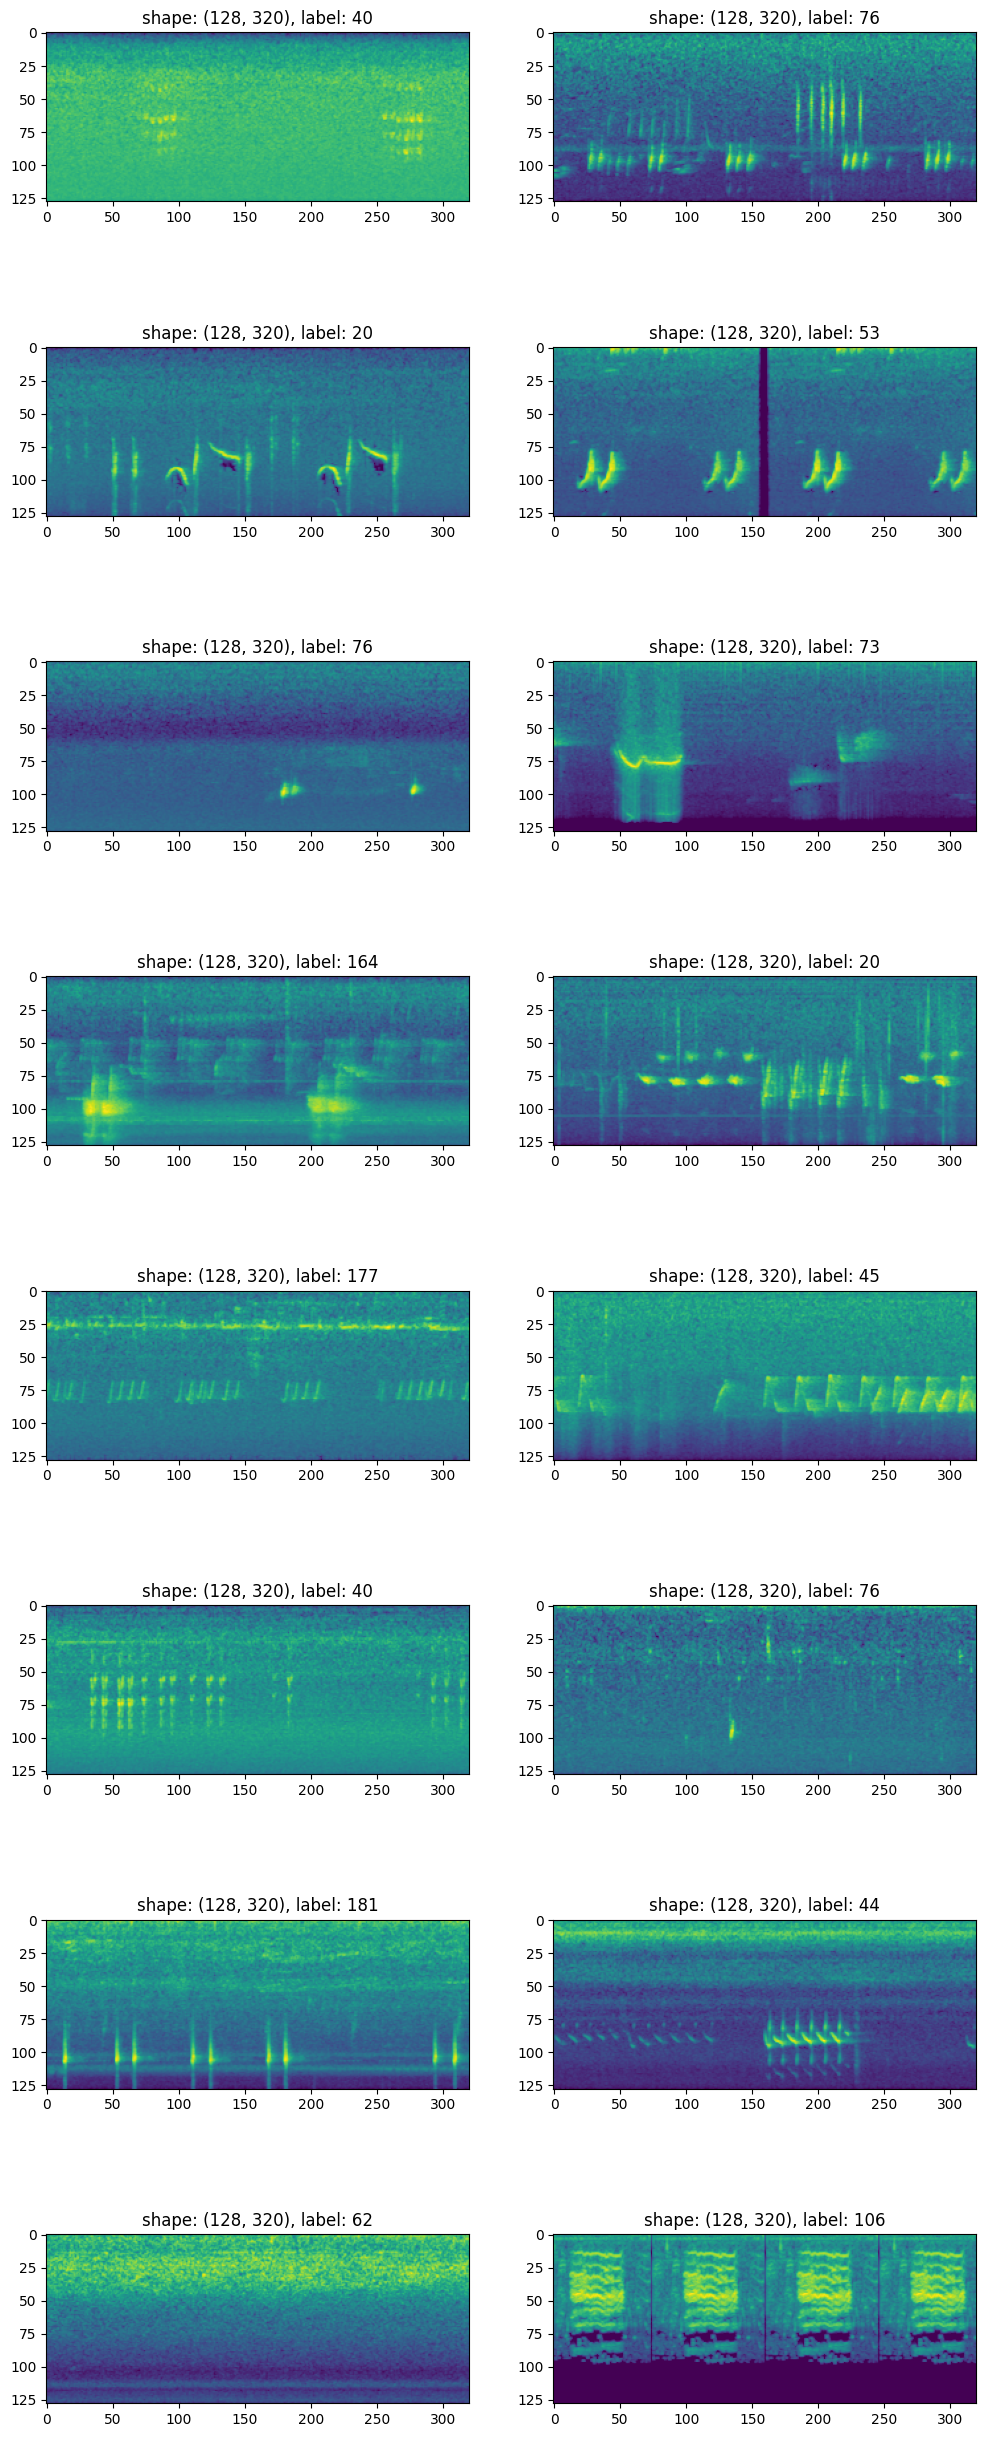

In [11]:
# Plot a training batch
def plot_batch(nrows=8, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*4))
    for r in range(nrows):
        for c in range(ncols):
            idx = (r * ncols) + c
            # Denormalize Image
            axes[r,c].imshow(X_batch[idx])
            axes[r,c].set_title(f'shape: {X_batch[idx].numpy().shape}, label: {tar[idx]}')
    plt.show()
    
plot_batch()


# Model

In [12]:
# Function to search for timm models
def search_timm_model(query):
    search_result = [n for n in timm.list_models(pretrained=True) if query in n]
    for i, name in enumerate(search_result):
        print(f'{i:02d} | {name}')
        
# search_timm_model('efficient')

In [13]:
# Count model parameters
def count_parameters(model):
    return sum([p.numel() for p in model.parameters()])

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # ImageNet Normalize Input
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        # Backbone
        self.backbone = timm.create_model(
                CONFIG.BACKBONE,
                pretrained=True,
                num_classes=CONFIG.N_CLASSES,
            )
        
    def forward(self, inputs):
        # Go From HxW → 3xHxW
        inputs = inputs.unsqueeze(1).expand(-1, 3, -1, -1)
        # Normalize [0-255] → [0-1]
        inputs = inputs.float() / 255
        # Normalize
        inputs = self.normalize(inputs)
        
        return self.backbone(inputs)

In [15]:
# Create new Model
model = Model().cuda()

# Number of parameters
print(f'# Model Parameters: {count_parameters(model):,}')

# Forward pass
with torch.no_grad():
    # Put inputs on GPU
    outputs = model(X_batch.cuda())
    print(f'outputs shape: {outputs.shape}, min: {outputs.min():.3f}, max: {outputs.max():.3f}')
    print(f'µ: {outputs.mean():.3f}, σ: {outputs.std():.3f}')

model.safetensors:   0%|          | 0.00/36.5M [00:00<?, ?B/s]

# Model Parameters: 7,792,406
outputs shape: torch.Size([16, 182]), min: -0.865, max: 0.863
µ: 0.009, σ: 0.243


# Learning Rate Scheduler

In [16]:
# Get the learning rate scheduler
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=2*CONFIG.N_STEPS,
        pct_start=0.10,
        anneal_strategy='cos',
        div_factor=1e3,
        final_div_factor=1e4,
    )

In [17]:
# Plot Learning Rate Scheduler
def plot_lr_scheduler():
    lr_scheduler = get_lr_scheduler(torch.optim.Adam(model.parameters()))
    lrs  = []
    for step in range(CONFIG.N_STEPS):
        lrs.append(lr_scheduler.get_last_lr())
        lr_scheduler.step()
    # Plot Learning Rate
    plt.figure(figsize=(12,5))
    plt.title('Learning Rate Schedule')
    plt.xticks(np.arange(0, CONFIG.N_STEPS+1, CONFIG.N_STEPS_PER_EPOCH), range(CONFIG.N_EPOCHS+1))
    plt.xlim(0, CONFIG.N_STEPS)
    plt.ylim(0, CONFIG.LR_MAX*1.1)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.plot(lrs)
    plt.grid()
    plt.show()
    # Reset Learning Rate Scheduler
    lr_scheduler._step_count = 0
    lr_scheduler.last_epoch = 0

# plot_lr_scheduler()

# Training

In [18]:
def mixup(x, y, alpha = 0.4):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    mixed_y = lam * y_a + (1 - lam) * y_b
    return mixed_x, mixed_y

def pitchshiftimage(image_batch, shift):
    n, h, w = image_batch.shape
    shifted_batch = torch.zeros_like(image_batch)
    if shift > 0:
        shifted_batch[:, shift:, :] = image_batch[:, :-shift, :]
    elif shift < 0:
        shifted_batch[:, :shift, :] = image_batch[:, -shift:, :]
    else:
        shifted_batch = image_batch
    return shifted_batch

In [19]:
# Average meter to keep track of metrics/loss during training
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.sum += val
        self.count = num
        # Average is simply the sum divided by the count
        self.avg = self.sum / self.count

In [20]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [21]:
# Loss
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)
# Learning Rate Scheduler
LR_SCHEDULER = get_lr_scheduler(optimizer)
# Metrics
LOSS = AverageMeter()
ACC = torchmetrics.Accuracy(task='multiclass', num_classes=CONFIG.N_CLASSES).cuda()
ROC_AUC = torchmetrics.AUROC(task='multiclass', num_classes=CONFIG.N_CLASSES).cuda()
ACC_VAL = torchmetrics.Accuracy(task='multiclass', num_classes=CONFIG.N_CLASSES).cuda()
ROC_AUC_VAL = torchmetrics.AUROC(task='multiclass', num_classes=CONFIG.N_CLASSES).cuda()

In [22]:
for epoch in range(CONFIG.N_EPOCHS):
    # Reset Metrics
    LOSS.reset()
    ACC.reset()
    ROC_AUC.reset()
    # Put model in training mode
    model.train()
    # Iterate Over Training Dataloader
    for step, (X_batch, y_true, tar) in enumerate(train_dataloader):
        if np.random.rand() < CONFIG.MIXUP_PROB:
            X_batch, y_true = mixup(X_batch, y_true)
        # Put batch on GPU
        X_batch = X_batch.cuda()
        y_true = y_true.cuda()
        tar = tar.cuda()
        # Step Time
        t_start = time.perf_counter()
        # Forward Pass
        y_pred = model(X_batch)
#         print(y_pred.softmax(dim=1).shape)
#         print(y_true.shape)
        # Loss
        loss = loss_fn(y_pred, y_true)
        # Update Loss Metrics
        LOSS.update(loss.item(),step+1)
        # Compute Gradients
        loss.backward()
        # Backward Pass
        optimizer.step()
        # Zero Out Gradients
        optimizer.zero_grad()
        # Update Metrics
        ACC.update(y_pred.softmax(dim=1), tar)
        ROC_AUC.update(y_pred.softmax(dim=1), tar)
        # Logs
        if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_STEPS_PER_EPOCH:
            print(
                f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' +
                f'loss: {LOSS.avg:.4f}, ACC: {ACC.compute():.3f}, ROC_AUC: {ROC_AUC.compute():.3f}, ' +
                f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
            )
        elif CONFIG.IS_INTERACTIVE:
            print(
                f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' +
                f'loss: {LOSS.avg:.4f}, ACC: {ACC.compute():.3f}, ROC_AUC: {ROC_AUC.compute():.3f}, ' +
                f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}'
                , end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else ' ' * 10 + '\r', flush=True,
            )
        del X_batch, y_true, y_pred, loss
        # Learning Rate Scheduler Step
        LR_SCHEDULER.step()
    model.eval()
    ACC_VAL.reset()
    ROC_AUC_VAL.reset()       
    with torch.no_grad():
        for step, (X_batch, y_true, tar) in enumerate(val_dataloader):
            # Put batch on GPU
            X_batch = X_batch.cuda()
            y_true = y_true.cuda()
            tar = tar.cuda()
            # Step Time
            t_start = time.perf_counter()
            # Forward Pass
            y_pred = model(X_batch)
            # Update Metrics
            ACC_VAL.update(y_pred.softmax(dim=1), tar)
            ROC_AUC_VAL.update(y_pred.softmax(dim=1), tar)
            # Logs
            if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_STEPS_PER_VAL_EPOCH:
                print(
                    f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_VAL_EPOCH} | ' +
                    f'ACC: {ACC_VAL.compute():.3f}, ROC_AUC: {ROC_AUC_VAL.compute():.3f}, ' +
                    f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                )
            elif CONFIG.IS_INTERACTIVE:
                print(
                    f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_VAL_EPOCH} | ' +
                    f'ACC: {ACC_VAL.compute():.3f}, ROC_AUC: {ROC_AUC_VAL.compute():.3f}, ' +
                    f'step: {(time.perf_counter()-t_start):.3f}s'
                    , end='\n' if (step + 1) == CONFIG.N_STEPS_PER_VAL_EPOCH else ' ' * 10 + '\r', flush=True,
                )
            del X_batch, y_true, y_pred
    

# Save entire model object
# torch.save(model, 'model.pth')

EPOCH 01 2622/2622 | loss: 3.2260, ACC: 0.294, ROC_AUC: 0.779, step: 0.511s, lr: 3.00e-04
EPOCH 01 1516/1516 | ACC: 0.484, ROC_AUC: 0.944, step: 0.177s, lr: 3.00e-04
EPOCH 02 2622/2622 | loss: 1.7855, ACC: 0.534, ROC_AUC: 0.898, step: 0.228s, lr: 2.83e-04
EPOCH 02 1516/1516 | ACC: 0.688, ROC_AUC: 0.966, step: 0.186s, lr: 2.83e-04
EPOCH 03 2622/2622 | loss: 1.3556, ACC: 0.615, ROC_AUC: 0.909, step: 0.227s, lr: 2.45e-04
EPOCH 03 1516/1516 | ACC: 0.681, ROC_AUC: 0.966, step: 0.174s, lr: 2.45e-04
EPOCH 04 2622/2622 | loss: 1.0002, ACC: 0.688, ROC_AUC: 0.921, step: 0.227s, lr: 1.90e-04
EPOCH 04 1516/1516 | ACC: 0.706, ROC_AUC: 0.969, step: 0.186s, lr: 1.90e-04


In [23]:
# for epoch in range(CONFIG.N_EPOCHS):
#     # Reset Metrics
#     LOSS.reset()
#     ACC.reset()
#     ROC_AUC.reset()
#     # Put model in training mode
#     model.train()
#     # Iterate Over Training Dataloader
#     for step, (X_batch, y_true) in enumerate(mix_dataloader):
#         # Put batch on GPU
#         X_batch = X_batch.cuda()
#         y_true = y_true.cuda()
#         # Step Time
#         t_start = time.perf_counter()
#         # Forward Pass
#         y_pred = model(X_batch)
#         # Loss
#         loss = loss_fn(y_pred, y_true)
#         # Update Loss Metrics
#         LOSS.update(loss.item(),step+1)
#         # Compute Gradients
#         loss.backward()
#         # Backward Pass
#         optimizer.step()
#         # Zero Out Gradients
#         optimizer.zero_grad()
#         # Update Metrics
#         ACC.update(y_pred.softmax(dim=1), y_true)
#         ROC_AUC.update(y_pred.softmax(dim=1), y_true)
#         # Logs
#         if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_STEPS_PER_3EPOCH:
#             print(
#                 f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_3EPOCH} | ' +
#                 f'loss: {LOSS.avg:.4f}, ACC: {ACC.compute():.3f}, ROC_AUC: {ROC_AUC.compute():.3f}, ' +
#                 f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
#             )
#         elif CONFIG.IS_INTERACTIVE:
#             print(
#                 f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_3EPOCH} | ' +
#                 f'loss: {LOSS.avg:.4f}, ACC: {ACC.compute():.3f}, ROC_AUC: {ROC_AUC.compute():.3f}, ' +
#                 f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}'
#                 , end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else ' ' * 10 + '\r', flush=True,
#             )
#         del X_batch, y_true, y_pred, loss
#         # Learning Rate Scheduler Step
#         LR_SCHEDULER.step()
#     model.eval()
#     ACC_VAL.reset()
#     ROC_AUC_VAL.reset()       
#     with torch.no_grad():
#         for step, (X_batch, y_true) in enumerate(val_dataloader):
#             # Put batch on GPU
#             X_batch = X_batch.cuda()
#             y_true = y_true.cuda()
#             # Step Time
#             t_start = time.perf_counter()
#             # Forward Pass
#             y_pred = model(X_batch)
#             # Update Metrics
#             ACC_VAL.update(y_pred.softmax(dim=1), y_true)
#             ROC_AUC_VAL.update(y_pred.softmax(dim=1), y_true)
#             # Logs
#             if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_STEPS_PER_VAL_EPOCH:
#                 print(
#                     f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_VAL_EPOCH} | ' +
#                     f'ACC: {ACC_VAL.compute():.3f}, ROC_AUC: {ROC_AUC_VAL.compute():.3f}, ' +
#                     f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
#                 )
#             elif CONFIG.IS_INTERACTIVE:
#                 print(
#                     f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_VAL_EPOCH} | ' +
#                     f'ACC: {ACC_VAL.compute():.3f}, ROC_AUC: {ROC_AUC_VAL.compute():.3f}, ' +
#                     f'step: {(time.perf_counter()-t_start):.3f}s'
#                     , end='\n' if (step + 1) == CONFIG.N_STEPS_PER_VAL_EPOCH else ' ' * 10 + '\r', flush=True,
#                 )
#             del X_batch, y_true, y_pred
    

# # Save entire model object
# # torch.save(model, 'model.pth')

In [24]:
for epoch in range(3):
    # Reset Metrics
    LOSS.reset()
    ACC.reset()
    ROC_AUC.reset()
    # Put model in training mode
    model.train()
    # Iterate Over Training Dataloader
    for step, (X_batch, y_true, tar) in enumerate(train2_dataloader):
        X_batch, y_true = mixup(X_batch, y_true)
        # Put batch on GPU
        X_batch = X_batch.cuda()
        y_true = y_true.cuda()
        tar = tar.cuda()
        # Step Time
        t_start = time.perf_counter()
        # Forward Pass
        y_pred = model(X_batch)
        # Loss
        loss = loss_fn(y_pred, y_true)
        # Update Loss Metrics
        LOSS.update(loss.item(),step+1)
        # Compute Gradients
        loss.backward()
        # Backward Pass
        optimizer.step()
        # Zero Out Gradients
        optimizer.zero_grad()
        # Update Metrics
        ACC.update(y_pred.softmax(dim=1), tar)
        ROC_AUC.update(y_pred.softmax(dim=1), tar)
        # Logs
        if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_STEPS_PER_2EPOCH:
            print(
                f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_2EPOCH} | ' +
                f'loss: {LOSS.avg:.4f}, ACC: {ACC.compute():.3f}, ROC_AUC: {ROC_AUC.compute():.3f}, ' +
                f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
            )
        elif CONFIG.IS_INTERACTIVE:
            print(
                f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_2EPOCH} | ' +
                f'loss: {LOSS.avg:.4f}, ACC: {ACC.compute():.3f}, ROC_AUC: {ROC_AUC.compute():.3f}, ' +
                f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}'
                , end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else ' ' * 10 + '\r', flush=True,
            )
        del X_batch, y_true, y_pred, loss
        # Learning Rate Scheduler Step
        LR_SCHEDULER.step()
    model.eval()
    ACC_VAL.reset()
    ROC_AUC_VAL.reset()       
    with torch.no_grad():
        for step, (X_batch, y_true, tar) in enumerate(val_dataloader):
            # Put batch on GPU
            X_batch = X_batch.cuda()
            y_true = y_true.cuda()
            tar = tar.cuda()
            # Step Time
            t_start = time.perf_counter()
            # Forward Pass
            y_pred = model(X_batch)
            # Update Metrics
            ACC_VAL.update(y_pred.softmax(dim=1), tar)
            ROC_AUC_VAL.update(y_pred.softmax(dim=1), tar)
            # Logs
            if not CONFIG.IS_INTERACTIVE and (step + 1) == CONFIG.N_STEPS_PER_VAL_EPOCH:
                print(
                    f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_VAL_EPOCH} | ' +
                    f'ACC: {ACC_VAL.compute():.3f}, ROC_AUC: {ROC_AUC_VAL.compute():.3f}, ' +
                    f'step: {(time.perf_counter()-t_start):.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                )
            elif CONFIG.IS_INTERACTIVE:
                print(
                    f'EPOCH {epoch+1:02d} {step+1:04d}/{CONFIG.N_STEPS_PER_VAL_EPOCH} | ' +
                    f'ACC: {ACC_VAL.compute():.3f}, ROC_AUC: {ROC_AUC_VAL.compute():.3f}, ' +
                    f'step: {(time.perf_counter()-t_start):.3f}s'
                    , end='\n' if (step + 1) == CONFIG.N_STEPS_PER_VAL_EPOCH else ' ' * 10 + '\r', flush=True,
                )
            del X_batch, y_true, y_pred
    

# Save entire model object
torch.save(model, 'model.pth')

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


EPOCH 01 0157/157 | loss: 2.4340, ACC: 0.322, ROC_AUC: 0.648, step: 0.262s, lr: 1.87e-04
EPOCH 01 1516/1516 | ACC: 0.713, ROC_AUC: 0.972, step: 0.164s, lr: 1.87e-04
EPOCH 02 0157/157 | loss: 1.7669, ACC: 0.484, ROC_AUC: 0.720, step: 0.204s, lr: 1.83e-04
EPOCH 02 1516/1516 | ACC: 0.705, ROC_AUC: 0.963, step: 0.161s, lr: 1.83e-04
EPOCH 03 0157/157 | loss: 1.3791, ACC: 0.492, ROC_AUC: 0.694, step: 0.199s, lr: 1.80e-04
EPOCH 03 1516/1516 | ACC: 0.714, ROC_AUC: 0.966, step: 0.169s, lr: 1.80e-04
